# Dog Breed Identification

For this project we are looking to accurately classify different dog breeds based on photos of different dogs.
Dataset is provided by Kaggle.com: https://www.kaggle.com/c/dog-breed-identification/data

In [1]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import os

In [2]:
import seaborn as sns
sns.set(font_scale=1.5)

## Exploring the Data

### Image Files

In [3]:
train_path = '../input/dog-breed-identification/train/'
test_path = '../input/dog-breed-identification/test/'

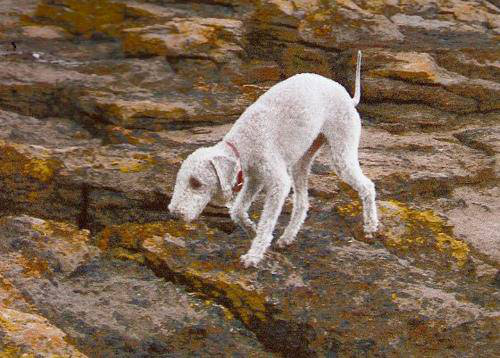

In [4]:
load_img(train_path+os.listdir(train_path)[100])

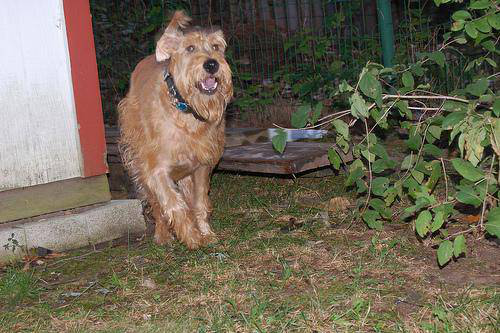

In [5]:
load_img(train_path+os.listdir(train_path)[40])

### Importing Dataframes

In [6]:
train_df = pd.read_csv('../input/dog-breed-identification/labels.csv')
test_df = pd.read_csv('../input/dog-breed-identification/sample_submission.csv')

In [7]:
train_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
train_df['id'].isna().sum()

0

In [9]:
train_df['breed'].nunique()

120

Let's look at dog breed frequency

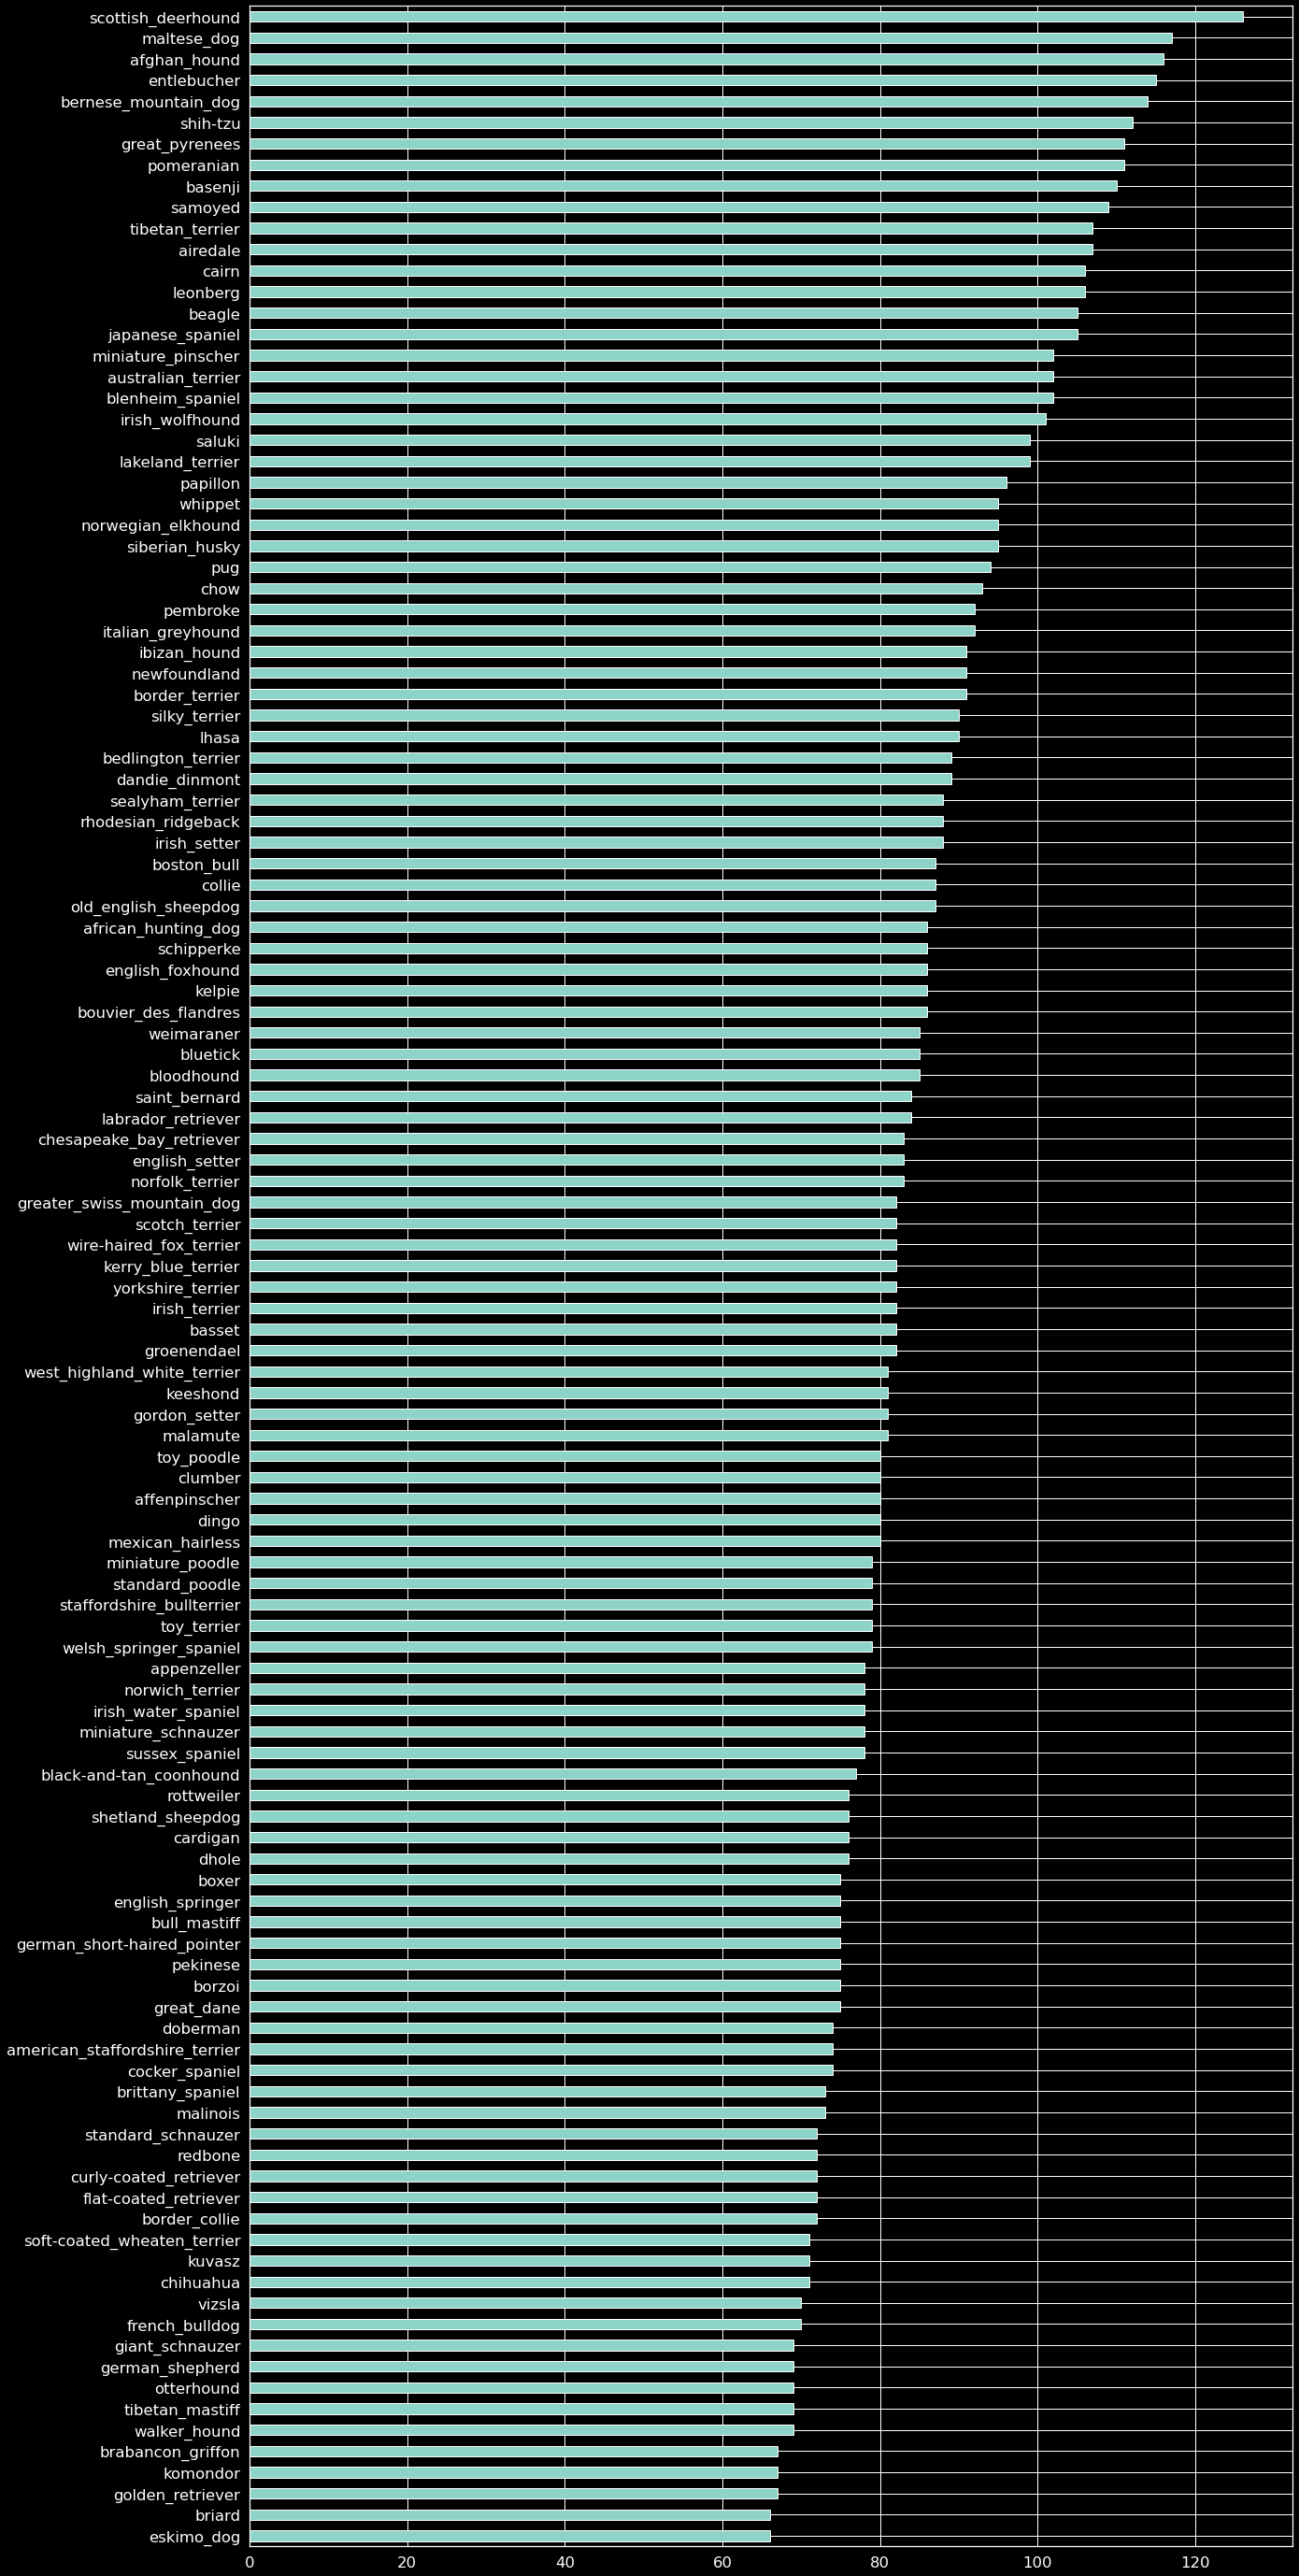

In [11]:
plt.figure(figsize=(20,50))
plt.style.use('dark_background')
train_df['breed'].value_counts().plot(kind='barh')
plt.gca().invert_yaxis();

We will be adding the image names into the given dataframes

In [12]:
train_df['image'] = [fname + '.jpg' for fname in train_df['id']]

In [13]:
len(train_df['id']), len(train_df['image'])

(10222, 10222)

In [14]:
train_df.head()

,id,breed,image
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,0021f9ceb3235effd7fcde7f7538ed62.jpg


boston_bull


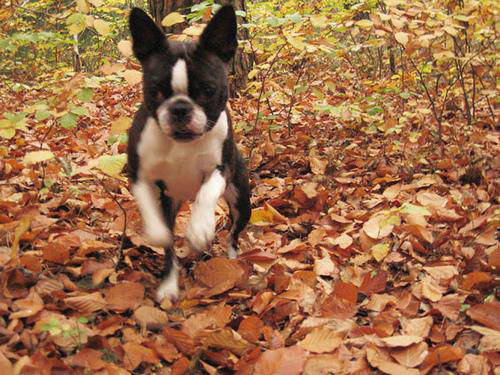

In [15]:
print(train_df['breed'][0])
load_img(train_path + train_df['image'][0])

In [16]:
test_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [17]:
test_df['image'] = [fname + '.jpg' for fname in test_df['id']]

In [18]:
test_df['image'].head(3)

0    000621fb3cbb32d8935728e48679680e.jpg
1    00102ee9d8eb90812350685311fe5890.jpg
2    0012a730dfa437f5f3613fb75efcd4ce.jpg
Name: image, dtype: object

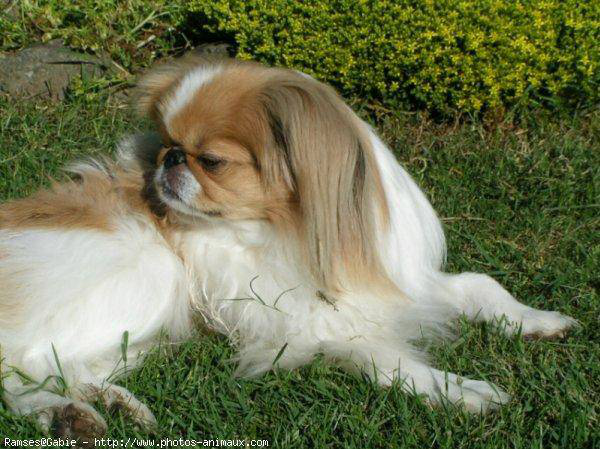

In [19]:
load_img(test_path + test_df['image'][0])

## Pretrained Models

We will be utilizing Keras pretrained models to classify breeds

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [21]:

gen = ImageDataGenerator(rescale=1./255.,
                        horizontal_flip=True,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        validation_split=0.2)
    
train_batches = gen.flow_from_dataframe(train_df,
                                        directory=train_path,
                                        x_col='image',
                                        y_col='breed',
                                        subset='training',
                                        target_size=(299,299),
                                        batch_size=32,
                                        seed=0)
    
valid_batches = gen.flow_from_dataframe(train_df,
                                        directory=train_path,
                                        x_col='image',
                                        y_col='breed',
                                        subset='validation',
                                        target_size=(299,299),
                                        batch_size=1,
                                        seed=0)
    
test_batches = ImageDataGenerator(rescale=1./255) \
                    .flow_from_dataframe(test_df,
                                         directory=test_path,
                                         x_col='image',
                                         y_col=None,
                                         target_size=(299,299),
                                         batch_size=1,
                                         seed=0,
                                         class_mode=None,
                                         shuffle=False)
    


Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.
Found 10357 validated image filenames.


### InceptionV3 Model

In [22]:
inception_model = tensorflow.keras.applications.inception_v3.InceptionV3(weights='imagenet', 
                                                                         include_top=False,
                                                                         input_shape=(299,299,3))

87916544/87910968 [==============================] - 1s 0us/step


In [23]:
#inception_model.summary()

In [24]:
inception_model.trainable=False

In [25]:
inputs = Input(shape=(299,299,3)) 
x = inception_model(inputs)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.35)(x)
output = Dense(120, activation='softmax')(x)
new_inception_model = Model(inputs=inputs,outputs=output)

In [26]:
#new_inception_model.summary()

In [27]:
new_inception_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
new_inception_model.fit(train_batches, validation_data=valid_batches, epochs=50, callbacks=[early_stop])

Epoch 1/50
256/256 [==============================] - 265s 1s/step - loss: 1.1569 - accuracy: 0.7159 - val_loss: 0.5457 - val_accuracy: 0.8386
Epoch 2/50
256/256 [==============================] - 247s 964ms/step - loss: 0.5138 - accuracy: 0.8544 - val_loss: 0.5975 - val_accuracy: 0.8283
Epoch 3/50
256/256 [==============================] - 249s 972ms/step - loss: 0.3879 - accuracy: 0.8837 - val_loss: 0.6719 - val_accuracy: 0.8386
Epoch 4/50
256/256 [==============================] - 249s 974ms/step - loss: 0.3368 - accuracy: 0.8988 - val_loss: 0.7483 - val_accuracy: 0.8297
Epoch 5/50
256/256 [==============================] - 250s 975ms/step - loss: 0.3074 - accuracy: 0.9047 - val_loss: 0.7193 - val_accuracy: 0.8469
Epoch 6/50
256/256 [==============================] - 249s 972ms/step - loss: 0.2510 - accuracy: 0.9166 - val_loss: 0.7315 - val_accuracy: 0.8371


In [30]:
prediction = new_inception_model.predict(test_batches, verbose=1)

10357/10357 [==============================] - 164s 16ms/step


In [33]:
labels = list(train_batches.class_indices.keys())
inception_v3_submission = pd.DataFrame(prediction,
                        columns=labels)
inception_v3_submission.insert(loc=0, column='id', value=test_df['id'])

In [34]:
inception_v3_submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,1.719386e-10,5.574124e-11,1.727963e-11,1.545459e-11,1.484447e-13,4.388893e-12,1.203477e-13,1.275191e-12,1.047463e-11,...,1.072865e-11,1.339312e-10,3.800135e-11,3.578730e-12,3.908355e-11,6.433076e-12,5.913989e-10,1.667399e-13,1.579405e-10,1.121554e-11
1,00102ee9d8eb90812350685311fe5890,1.245342e-09,1.593856e-09,1.757511e-09,4.208665e-09,1.751982e-09,2.431963e-09,1.408688e-10,2.285491e-08,4.466143e-09,...,5.789702e-09,2.943720e-09,2.302920e-08,2.802613e-09,6.832420e-09,7.508770e-09,2.706258e-07,4.129518e-11,5.812274e-09,2.342805e-10
2,0012a730dfa437f5f3613fb75efcd4ce,4.779799e-10,9.410808e-07,4.154812e-07,3.020488e-09,2.046239e-11,3.663876e-10,7.628809e-10,1.859588e-09,2.417877e-09,...,6.093642e-10,1.205650e-08,3.870113e-10,1.155235e-09,4.394204e-10,2.886686e-06,2.687874e-11,5.323842e-08,4.711082e-07,3.286980e-09
3,001510bc8570bbeee98c8d80c8a95ec1,1.080326e-06,1.017260e-09,2.752298e-09,7.101099e-08,6.425131e-11,1.031795e-09,1.237950e-10,2.113651e-10,1.517889e-09,...,5.656724e-10,1.056604e-12,3.368568e-08,2.419373e-10,7.255278e-10,8.558040e-10,2.844076e-10,3.642231e-10,2.034053e-12,3.835579e-09
4,001a5f3114548acdefa3d4da05474c2e,4.089646e-05,2.087512e-07,1.592999e-08,9.517329e-09,1.132358e-08,8.392956e-10,1.457236e-08,4.514204e-08,1.042207e-06,...,1.116545e-08,1.241659e-07,2.420588e-08,1.835371e-08,3.454064e-08,1.381900e-07,6.587361e-08,1.396646e-09,1.111546e-06,5.095491e-06


In [35]:
inception_v3_submission.to_csv('inception_v3_submission.csv', index=False)

### InceptionResnetV2

In [36]:
inception_res_model = tensorflow.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet',
                                                                                         include_top=False,
                                                                                         input_shape=(299,299,3))

219062272/219055592 [==============================] - 2s 0us/step


In [38]:
#inception_res_model.summary()

In [39]:
inception_res_model.trainable = False

In [40]:
inputs = Input(shape=(299,299,3))
x = inception_res_model(inputs)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.35)(x)
output = Dense(120, activation='softmax')(x)
new_inception_res_model = Model(inputs=inputs, outputs=output)

In [41]:
new_inception_res_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
new_inception_res_model.fit(train_batches, validation_data=valid_batches, epochs=50, callbacks=[early_stop])

Epoch 1/50
256/256 [==============================] - 289s 1s/step - loss: 0.9203 - accuracy: 0.7886 - val_loss: 0.4562 - val_accuracy: 0.8694
Epoch 2/50
256/256 [==============================] - 285s 1s/step - loss: 0.4663 - accuracy: 0.8734 - val_loss: 0.5238 - val_accuracy: 0.8586
Epoch 3/50
256/256 [==============================] - 287s 1s/step - loss: 0.4179 - accuracy: 0.8853 - val_loss: 0.5855 - val_accuracy: 0.8615
Epoch 4/50
256/256 [==============================] - 287s 1s/step - loss: 0.3725 - accuracy: 0.8968 - val_loss: 0.5753 - val_accuracy: 0.8684
Epoch 5/50
256/256 [==============================] - 289s 1s/step - loss: 0.3399 - accuracy: 0.9014 - val_loss: 0.5743 - val_accuracy: 0.8767
Epoch 6/50
256/256 [==============================] - 289s 1s/step - loss: 0.3268 - accuracy: 0.9061 - val_loss: 0.5893 - val_accuracy: 0.8669


In [43]:
prediction = new_inception_res_model.predict(test_batches, verbose=1)

10357/10357 [==============================] - 398s 38ms/step


In [44]:
labels = list(train_batches.class_indices.keys())
inception_resnet_submission = pd.DataFrame(prediction, columns=labels)
inception_resnet_submission.insert(loc=0, column='id', value=test_df['id'])

In [45]:
inception_resnet_submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,2.986995e-09,2.876770e-09,3.010822e-10,4.604805e-09,5.089727e-10,8.959842e-11,2.346911e-10,3.408874e-09,3.800095e-10,...,6.753759e-10,3.084980e-10,2.591579e-09,7.588783e-09,2.875592e-08,1.184883e-09,1.576731e-08,1.372418e-11,1.750424e-07,1.298931e-10
1,00102ee9d8eb90812350685311fe5890,2.579042e-11,5.406052e-10,2.257885e-10,9.950766e-10,1.766114e-09,1.001885e-09,4.987459e-09,1.019899e-08,5.943718e-11,...,1.677384e-09,4.350975e-10,8.591855e-09,2.802165e-09,3.990639e-10,5.956864e-10,1.775854e-07,1.022037e-10,5.449702e-09,5.465601e-12
2,0012a730dfa437f5f3613fb75efcd4ce,1.206966e-10,7.373367e-10,1.271523e-08,5.791585e-10,4.088562e-09,4.046928e-10,1.168054e-10,3.377583e-10,4.374875e-08,...,1.579396e-09,4.317608e-09,4.997370e-08,2.564920e-08,4.752379e-08,9.057196e-07,9.952749e-10,8.678059e-07,5.390382e-08,1.252953e-10
3,001510bc8570bbeee98c8d80c8a95ec1,2.336062e-07,6.246931e-09,1.137761e-09,9.081364e-09,1.026804e-10,1.180885e-06,3.643149e-09,6.882537e-09,8.586612e-08,...,4.628003e-07,6.793818e-10,1.389096e-09,1.282335e-08,1.266653e-06,8.345732e-08,5.534889e-08,3.098189e-08,3.042710e-10,1.030086e-08
4,001a5f3114548acdefa3d4da05474c2e,1.888389e-05,6.251023e-08,2.815233e-07,1.539742e-07,3.025538e-08,5.416879e-09,6.986235e-08,6.370300e-07,3.213737e-06,...,4.605176e-07,3.129908e-07,1.407408e-08,7.119203e-08,5.543416e-08,9.656048e-08,2.158887e-08,1.972842e-07,5.788454e-07,1.092443e-06


In [46]:
inception_resnet_submission.to_csv('InceptionResnetV2_submission.csv', index=False)

Kaggle Score:
* InceptionV3 Model: 0.57165
* InceptionResnetV2: 0.50288